# Decision Tree Model with One Hot Encoder for Categorical Variables

- Clean code version
- This version produced to produce a better tree diagram figure
- Also added state space search for meta parameter tuning

AUC: First test if optimizing for a threshold other than 0.5 produces a better accuracy, given that the default prediction should be about 0.78.

- Result: Might be slightly better, but difficult to tell from the numbers

Now that I have a function to calculate AUC, plot AUC as a function of the parameters

In [1]:
%load_ext autoreload
%autoreload 2

In [94]:
import math
import pandas
import numpy
import itertools
import matplotlib.pyplot as plt
import sklearn
from sklearn import tree
from sklearn.metrics import log_loss
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.naive_bayes import CategoricalNB

In [3]:
import loan_approval_lib
from loan_approval_lib import logspace, linspace

In [4]:
from loan_approval_lib.standard_data_processing import data_cleaning_algorithm
from loan_approval_lib.standard_data_processing import create_loan_grade_numerical_from_loan_grade
from loan_approval_lib.standard_data_processing import create_person_home_ownership_one_hot_encoder
from loan_approval_lib.standard_data_processing import create_person_home_ownership_one_hot
from loan_approval_lib.standard_data_processing import create_loan_intent_one_hot_encoder
from loan_approval_lib.standard_data_processing import create_loan_intent_one_hot
from loan_approval_lib.standard_data_processing import map_cb_person_default_on_file
from loan_approval_lib.standard_data_processing import create_decision_tree_columns
from loan_approval_lib.standard_data_processing import create_decision_tree_columns_with_id
from loan_approval_lib.standard_data_processing import create_dataframe_copy_and_drop_columns
from loan_approval_lib.standard_data_processing import create_decision_tree_columns
from loan_approval_lib.standard_data_processing import create_decision_tree_columns_with_id

In [5]:
data = loan_approval_lib.load_original_data()

In [6]:
data_train = loan_approval_lib.load_data_train()

In [7]:
data_test = loan_approval_lib.load_data_test()

# Data Cleaning

In [8]:
data = data_cleaning_algorithm(data)

column person_age, number of removed rows: 5
column person_income, number of removed rows: 0
column person_emp_length, number of removed rows: 897
column loan_amnt, number of removed rows: 0
column loan_int_rate, number of removed rows: 3047
column loan_percent_income, number of removed rows: 0
column cb_person_default_on_file, number of removed rows: 0


In [9]:
data_train = data_cleaning_algorithm(data_train)

column person_age, number of removed rows: 1
column person_income, number of removed rows: 0
column person_emp_length, number of removed rows: 2
column loan_amnt, number of removed rows: 0
column loan_int_rate, number of removed rows: 0
column loan_percent_income, number of removed rows: 0
column cb_person_default_on_file, number of removed rows: 0


In [10]:
data_cleaning_algorithm(data_test)
None

column person_age, number of removed rows: 0
column person_income, number of removed rows: 0
column person_emp_length, number of removed rows: 0
column loan_amnt, number of removed rows: 0
column loan_int_rate, number of removed rows: 0
column loan_percent_income, number of removed rows: 0
column cb_person_default_on_file, number of removed rows: 0


In [11]:
# Loan Grade

create_loan_grade_numerical_from_loan_grade(data, data_train, data_test)

In [12]:
# Person Home Ownership

encoder = create_person_home_ownership_one_hot_encoder(data)

data = create_person_home_ownership_one_hot(encoder, data)
data_train = create_person_home_ownership_one_hot(encoder, data_train)
data_test = create_person_home_ownership_one_hot(encoder, data_test)

In [13]:
# Loan Intent

encoder = create_loan_intent_one_hot_encoder(data)

data = create_loan_intent_one_hot(encoder, data)
data_train = create_loan_intent_one_hot(encoder, data_train)
data_test = create_loan_intent_one_hot(encoder, data_test)

In [14]:
# Default On File

data = map_cb_person_default_on_file(data)
data_train = map_cb_person_default_on_file(data_train)
data_test = map_cb_person_default_on_file(data_test)

# Choose Columns for Tree Model, Copy DataFrame and Drop Unused Columns

In [15]:
decision_tree_columns = create_decision_tree_columns()
decision_tree_columns_with_id = create_decision_tree_columns_with_id()

In [16]:
data_copy = create_dataframe_copy_and_drop_columns(data)
data_train_copy = create_dataframe_copy_and_drop_columns(data_train)
data_test_copy = create_dataframe_copy_and_drop_columns(data_test)

# Optimize Choice of Dataset

In [17]:
all_training_data = pandas.concat(
    [data_copy, data_train_copy],
    axis=0,
)
all_training_data.reset_index(inplace=True, drop=True)

In [18]:
permutation = numpy.random.permutation(all_training_data.index)

In [19]:
n_samples = len(all_training_data)
n_samples

87274

In [20]:
k = 100

In [21]:
fold_sizes = numpy.full(k, n_samples // k, dtype=int)
fold_sizes

array([872, 872, 872, 872, 872, 872, 872, 872, 872, 872, 872, 872, 872,
       872, 872, 872, 872, 872, 872, 872, 872, 872, 872, 872, 872, 872,
       872, 872, 872, 872, 872, 872, 872, 872, 872, 872, 872, 872, 872,
       872, 872, 872, 872, 872, 872, 872, 872, 872, 872, 872, 872, 872,
       872, 872, 872, 872, 872, 872, 872, 872, 872, 872, 872, 872, 872,
       872, 872, 872, 872, 872, 872, 872, 872, 872, 872, 872, 872, 872,
       872, 872, 872, 872, 872, 872, 872, 872, 872, 872, 872, 872, 872,
       872, 872, 872, 872, 872, 872, 872, 872, 872])

In [22]:
fold_sizes[:n_samples % k] += 1
fold_sizes

array([873, 873, 873, 873, 873, 873, 873, 873, 873, 873, 873, 873, 873,
       873, 873, 873, 873, 873, 873, 873, 873, 873, 873, 873, 873, 873,
       873, 873, 873, 873, 873, 873, 873, 873, 873, 873, 873, 873, 873,
       873, 873, 873, 873, 873, 873, 873, 873, 873, 873, 873, 873, 873,
       873, 873, 873, 873, 873, 873, 873, 873, 873, 873, 873, 873, 873,
       873, 873, 873, 873, 873, 873, 873, 873, 873, 872, 872, 872, 872,
       872, 872, 872, 872, 872, 872, 872, 872, 872, 872, 872, 872, 872,
       872, 872, 872, 872, 872, 872, 872, 872, 872])

In [23]:
index = 0
folds = []
for fold_size in fold_sizes:
    start = index
    stop = index + fold_size
    folds.append(permutation[start:stop])
    index = stop

# Decision Tree Model

In [24]:
def decision_tree_model_train(
    data_train,
    decision_tree_columns,
    max_depth,
    min_samples_split,
    max_leaf_nodes,
    min_samples_leaf,
    min_impurity_decrease,
):
    
    X = data_train[decision_tree_columns].copy()
    Y = data_train['loan_status'].copy()
    
    clf = tree.DecisionTreeClassifier(
        criterion='entropy',
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=None,
        max_leaf_nodes=max_leaf_nodes,
        min_impurity_decrease=min_impurity_decrease,
    )
    clf = clf.fit(X, Y)

    feature_importances = pandas.Series(clf.feature_importances_, index=X.columns).sort_values(ascending=False)
    feature_importances = feature_importances[feature_importances > 0]

    Z = clf.predict(X)
    X['loan_status_predict'] = Z
    X['loan_status'] = data_train['loan_status']
    accuracy_in_sample = (X['loan_status'] == X['loan_status_predict']).sum() / len(X)

    return (clf, feature_importances, accuracy_in_sample)

In [25]:
def decision_tree_model_test(
    clf,
    data_test,
    decision_tree_columns,
):

    X_test = data_test[decision_tree_columns].copy()
    
    Z_test = clf.predict(X_test)
    X_test['loan_status_predict'] = Z_test
    X_test['loan_status'] = data_test['loan_status']
    accuracy_out_of_sample = (X_test['loan_status'] == X_test['loan_status_predict']).sum() / len(X_test)
    
    return accuracy_out_of_sample

In [26]:
def decision_tree_model_predict_proba(
    clf,
    data_test,
    decision_tree_columns,
):
    
    X_test = data_test[decision_tree_columns].copy()
    
    Z_test = clf.predict_proba(X_test)[:, 1]

    return Z_test

In [27]:
def decision_tree_model_test_threshold(
    clf,
    data_test,
    decision_tree_columns,
    threshold,
):

    X_test = data_test[decision_tree_columns].copy()

    Z_test = (clf.predict_proba(X_test)[:, 1]) > threshold
    X_test['loan_status_predict'] = Z_test
    X_test['loan_status'] = data_test['loan_status']
    accuracy = (X_test['loan_status'] == X_test['loan_status_predict']).sum() / len(X_test)
    
    return accuracy

In [28]:
def decision_tree_model_test_TPR_FPR(
    clf,
    data_test,
    decision_tree_columns,
    threshold,
):

    X_test = data_test[decision_tree_columns].copy()

    Z_test = (clf.predict_proba(X_test)[:, 1]) > threshold
    X_test['loan_status_predict'] = Z_test
    X_test['loan_status'] = data_test['loan_status']

    true_positive  = len(X_test[(X_test['loan_status'] == 1) & (X_test['loan_status_predict'] == 1)]) # positive, same -> true
    false_positive = len(X_test[(X_test['loan_status'] == 0) & (X_test['loan_status_predict'] == 1)]) # positive, different -> false
    true_negative  = len(X_test[(X_test['loan_status'] == 0) & (X_test['loan_status_predict'] == 0)]) # negative, same -> true
    false_negative = len(X_test[(X_test['loan_status'] == 1) & (X_test['loan_status_predict'] == 0)]) # negative, different -> false

    tpr = true_positive / (true_positive + false_negative)
    fpr = false_positive / (false_positive + true_negative)

    return (tpr, fpr)

In [97]:
def decision_tree_model_test_AUC(
    clf,
    data_test,
    decision_tree_columns,
):
    # create threshold array
    # this code creates `threshold_array`, and it is sorted in ascending order
    
    data_predict = decision_tree_model_predict(
        clf,
        data_test,
        decision_tree_columns,
        decision_tree_columns_with_id,
    )
    
    threshold_array = numpy.concatenate(
        (
            numpy.array([-numpy.inf]),
            numpy.unique(data_predict['loan_status']),
            numpy.array([1.1]),
        )
    )

    # use threshold array to calculate TPR and FPR
    count = len(threshold_array)

    tpr_array = numpy.zeros(shape=(count,), dtype=float)
    fpr_array = numpy.zeros(shape=(count,), dtype=float)
    
    for i, threshold in enumerate(threshold_array):
        (tpr, fpr) = decision_tree_model_test_TPR_FPR(
            clf,
            test_data,
            decision_tree_columns,
            threshold,
        )
    
        threshold_array[i] = threshold
        tpr_array[i] = tpr
        fpr_array[i] = fpr
    
    sort_index = numpy.argsort(fpr_array)
    tpr_array = tpr_array[sort_index]
    fpr_array = fpr_array[sort_index]
    threshold_array = threshold_array[sort_index]

    # calculate threshold array, TPR and FPR
    # (roc_curve_fpr, roc_curve_tpr, roc_curve_threshold) = roc_curve(
    #     test_data['loan_status'],
    #     decision_tree_model_predict_proba(clf, test_data, decision_tree_columns),
    # )
    # may not include the -inf and +inf bounds?

    # use TPR and FPR to calculate AUC
    roc_auc = auc(fpr_array, tpr_array)
    #roc_auc = auc(roc_curve_fpr, roc_curve_tpr)
    
    return roc_auc

In [29]:
def decision_tree_model_predict(
    clf,
    data_predict,
    decision_tree_columns,
    decision_tree_columns_with_id,
):
    
    X_predict = data_predict[decision_tree_columns_with_id].copy()

    Z_predict = clf.predict_proba(X_predict[decision_tree_columns])
    X_predict['loan_status'] = Z_predict[:, 1]

    return X_predict

In [30]:
def decision_tree_model_predict_write_to_csv(
    data_predict,
    filename,
):
    data_predict[['id', 'loan_status']].to_csv(filename, index=False)

# Optimize on all data - produce ROC curve

- Train original good performing model, min samples split 30, min samples leaf 4
- Train using slightly worse model where max depth was optimized to 100

In [83]:
# train with everything

max_depth = None #100
min_samples_split = 30 #2
max_leaf_nodes = None
min_samples_leaf = 4 #1
min_impurity_decrease = 0.0

i = 0

test_index = folds[i]
train_index = numpy.concatenate([folds[j] for j in range(k) if j != i])
            
training_data = all_training_data.loc[train_index]
test_data = all_training_data.loc[test_index]

(
    clf,
    feature_importances,
    accuracy_in_sample,
) = decision_tree_model_train(
    training_data,
    decision_tree_columns,
    max_depth,
    min_samples_split,
    max_leaf_nodes,
    min_samples_leaf,
    min_impurity_decrease,
)

accuracy_out_of_sample = decision_tree_model_test(
    clf,
    test_data,
    decision_tree_columns,
)

(tpr, fpr) = decision_tree_model_test_TPR_FPR(
    clf,
    test_data,
    decision_tree_columns,
    0.5,
)

# data_predict = decision_tree_model_predict(
#     clf,
#     data_test_copy,
#     decision_tree_columns,
#     decision_tree_columns_with_id,
# )

#decision_tree_model_predict_write_to_csv(
#    data_predict,
#    f'decision_tree_model_one_hot_encoder_2_clean_code-2-max_depth_100_all_training_data.csv'
#)

In [109]:
# train with everything

max_depth = 100
min_samples_split = 2
max_leaf_nodes = None
min_samples_leaf = 1
min_impurity_decrease = 0.0

i = 0

test_index = folds[i]
train_index = numpy.concatenate([folds[j] for j in range(k) if j != i])
            
training_data = all_training_data.loc[train_index]
test_data = all_training_data.loc[test_index]

(
    clf,
    feature_importances,
    accuracy_in_sample,
) = decision_tree_model_train(
    training_data,
    decision_tree_columns,
    max_depth,
    min_samples_split,
    max_leaf_nodes,
    min_samples_leaf,
    min_impurity_decrease,
)

accuracy_out_of_sample = decision_tree_model_test(
    clf,
    test_data,
    decision_tree_columns,
)

(tpr, fpr) = decision_tree_model_test_TPR_FPR(
    clf,
    test_data,
    decision_tree_columns,
    0.5,
)

# data_predict = decision_tree_model_predict(
#     clf,
#     data_test_copy,
#     decision_tree_columns,
#     decision_tree_columns_with_id,
# )

#decision_tree_model_predict_write_to_csv(
#    data_predict,
#    f'decision_tree_model_one_hot_encoder_2_clean_code-2-max_depth_100_all_training_data.csv'
#)

In [84]:
# test AUC calculation
# looks good

decision_tree_model_test_AUC(
    clf,
    test_data,
    decision_tree_columns,
)

np.float64(0.909070889261745)

In [32]:
accuracy_in_sample

np.float64(0.9541903450191549)

In [33]:
accuracy_out_of_sample

np.float64(0.9415807560137457)

In [34]:
tpr

0.703125

In [35]:
fpr

0.0174496644295302

In [66]:
# this code creates `threshold_array`, and it is sorted in ascending order

data_predict = decision_tree_model_predict(
    clf,
    data_test_copy,
    decision_tree_columns,
    decision_tree_columns_with_id,
)

threshold_array = numpy.concatenate(
    (
        numpy.array([-numpy.inf]),
        numpy.unique(data_predict['loan_status']),
        numpy.array([1.1]),
    )
)

In [47]:
len(threshold_array)

202

In [ ]:
# this code creates TPR and FPR for calculation of AUC

In [48]:
count = len(threshold_array)

tpr_array = numpy.zeros(shape=(count,), dtype=float)
fpr_array = numpy.zeros(shape=(count,), dtype=float)

for i, threshold in enumerate(threshold_array):
    (tpr, fpr) = decision_tree_model_test_TPR_FPR(
        clf,
        test_data,
        decision_tree_columns,
        threshold,
    )

    threshold_array[i] = threshold
    tpr_array[i] = tpr
    fpr_array[i] = fpr

sort_index = numpy.argsort(fpr_array)
tpr_array = tpr_array[sort_index]
fpr_array = fpr_array[sort_index]
threshold_array = threshold_array[sort_index]

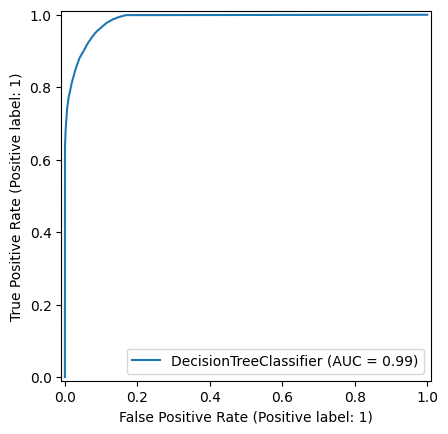

In [52]:
from sklearn.metrics import RocCurveDisplay

X = data_train[decision_tree_columns].copy()
Y = data_train['loan_status'].copy()

roc_curve_display = RocCurveDisplay.from_estimator(clf, X, Y)

In [49]:
numpy.trapezoid(tpr_array, x=fpr_array)

np.float64(0.9090132130872485)

In [50]:
roc_auc = auc(fpr_array, tpr_array)
roc_auc

np.float64(0.9090132130872485)

In [75]:
(roc_curve_fpr, roc_curve_tpr, roc_curve_threshold) = roc_curve(
    test_data['loan_status'],
    decision_tree_model_predict_proba(clf, test_data, decision_tree_columns),
)

In [76]:
roc_curve_fpr[0], roc_curve_tpr[0]

(np.float64(0.0), np.float64(0.0))

In [77]:
roc_curve_fpr[1], roc_curve_tpr[1]

(np.float64(0.0013422818791946308), np.float64(0.5390625))

In [78]:
roc_curve_fpr[-2], roc_curve_tpr[-2]

(np.float64(0.18791946308724833), np.float64(0.8671875))

In [79]:
roc_curve_fpr[-1], roc_curve_tpr[-1]

(np.float64(1.0), np.float64(1.0))

In [80]:
roc_auc = auc(roc_curve_fpr, roc_curve_tpr)
roc_auc

np.float64(0.9090551593959733)

In [ ]:
# this figure uses the values calculated from sklearn's `roc_curve`

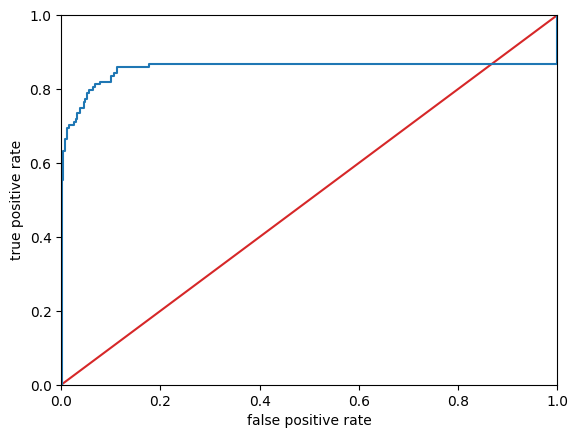

In [81]:
plt.figure()

plt.plot([0.0, 1.0], [0.0, 1.0], color='tab:red')
plt.step(
    roc_curve_fpr,
    roc_curve_tpr,
    where='post',
)

plt.xlabel('false positive rate')
plt.ylabel('true positive rate')

plt.xlim(0.0, 1.0)
plt.ylim(0.0, 1.0)

None

In [ ]:
# this figure uses the manually calculated `fpr_array` and `tpr_array`

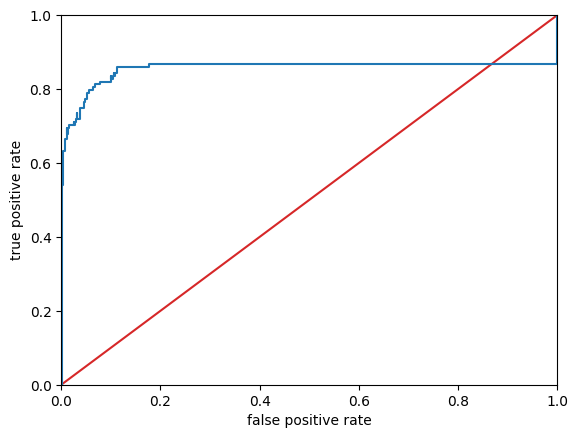

In [51]:
plt.figure()

plt.plot([0.0, 1.0], [0.0, 1.0], color='tab:red')
plt.step(
    fpr_array,
    tpr_array,
    where='post',
)

plt.xlabel('false positive rate')
plt.ylabel('true positive rate')

plt.xlim(0.0, 1.0)
plt.ylim(0.0, 1.0)

None

# Plot the distribution of `predict_proba` values

In [270]:
data_predict = decision_tree_model_predict(
    clf,
    data_test_copy,
    decision_tree_columns,
    decision_tree_columns_with_id,
)

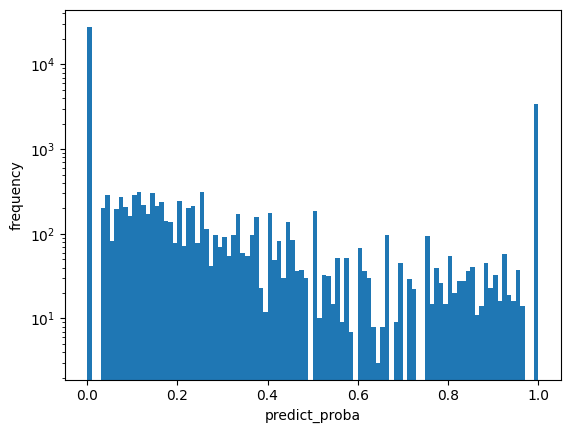

In [60]:
plt.figure()
plt.hist(data_predict['loan_status'], bins=100)
plt.yscale('log')

plt.xlabel('predict_proba')
plt.ylabel('frequency')

None

In [68]:
# this code creates `threshold_array`, and it is sorted in ascending order

data_predict = decision_tree_model_predict(
    clf,
    data_test_copy,
    decision_tree_columns,
    decision_tree_columns_with_id,
)

threshold_array = numpy.concatenate(
    (
        numpy.array([-numpy.inf]),
        numpy.unique(data_predict['loan_status']),
        numpy.array([1.1]),
    )
)

In [70]:
count = len(threshold_array)

accuracy_array = numpy.zeros(shape=(count,), dtype=float)

for i, threshold in enumerate(threshold_array):
    accuracy = decision_tree_model_test_threshold(
        clf,
        test_data,
        decision_tree_columns,
        threshold,
    )

    threshold_array[i] = threshold
    accuracy_array[i] = accuracy

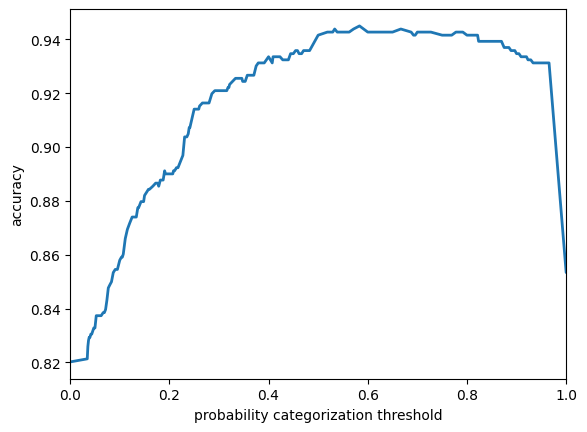

In [73]:
plt.figure()

plt.plot(
    threshold_array,
    accuracy_array,
    linewidth=2,
)

plt.ylabel('accuracy')
plt.xlabel('probability categorization threshold')
plt.xlim(0.0, 1.0)

None

# Decision Tree Model - Max Depth

In [104]:
df = pandas.read_csv(filename, index_col=0)
df

,max_depth,min_samples_split,max_leaf_nodes,min_samples_leaf,min_impurity_decrease,accuracy_in_sample,accuracy_out_of_sample
0,1.0,2,none,1,0.0,0.870407,0.872852
1,1.0,2,none,1,0.0,0.870534,0.860252
2,1.0,2,none,1,0.0,0.870580,0.855670
3,1.0,2,none,1,0.0,0.870441,0.869416
4,1.0,2,none,1,0.0,0.870499,0.863688
...,...,...,...,...,...,...,...
1895,none,2,none,1,0.0,0.999977,0.902523
1896,none,2,none,1,0.0,0.999977,0.925459
1897,none,2,none,1,0.0,0.999977,0.913991
1898,none,2,none,1,0.0,0.999977,0.917431


In [98]:
max_depth = None
min_samples_split = 2
max_leaf_nodes = None
min_samples_leaf = 1
min_impurity_decrease = 0.0

accuracy_in_sample_list = []
accuracy_out_of_sample_list = []
auc_list = []
max_depth_list = []
min_samples_split_list = []
max_leaf_nodes_list = []
min_samples_leaf_list = []
min_impurity_decrease_list = []

max_depth_list_input = [
    1, 2, 3, 4, 5, 6, 7, 8, 9, 10,
    12, 14, 16, 18, 20,
    25, 30, 35, 40, 50, 60, 70, 80, 90, 100,
]
min_samples_split_list_input = [2, 3, 4, 5, 7, 10, 20]
max_leaf_nodes_list_input = [2, 4, 8, 16, 32]
min_samples_leaf_list_input = [1, 2, 4, 8, 16, 32]
min_impurity_decrease_list_input = [0.0, 0.001, 0.01, 0.1]

filename = f'decision_tree_model_by_max_depth_AUC.csv'

df = None

for max_depth in max_depth_list_input:
    print(f'processing max_depth={max_depth}')

    # read data from file
    if df is None:
        try:
            df = pandas.read_csv(filename, index_col=0)
        except:
            pass

        if df is not None:
            accuracy_in_sample_list = df['accuracy_in_sample'].to_numpy().tolist()
            accuracy_out_of_sample_list = df['accuracy_out_of_sample'].to_numpy().tolist()
            auc_list = df['auc'].to_numpy().tolist()
            max_depth_list = df['max_depth'].to_numpy().tolist()
            min_samples_split_list = df['min_samples_split'].to_numpy().tolist()
            max_leaf_nodes_list = df['max_leaf_nodes'].to_numpy().tolist()
            min_samples_leaf_list = df['min_samples_leaf'].to_numpy().tolist()
            min_impurity_decrease_list = df['min_impurity_decrease'].to_numpy().tolist()
    
    for i in range(k):
        test_index = folds[i]
        train_index = numpy.concatenate([folds[j] for j in range(k) if j != i])
            
        training_data = all_training_data.loc[train_index]
        test_data = all_training_data.loc[test_index]
        
        (
            clf,
            feature_importances,
            accuracy_in_sample,
        ) = decision_tree_model_train(
            training_data,
            decision_tree_columns,
            max_depth,
            min_samples_split,
            max_leaf_nodes,
            min_samples_leaf,
            min_impurity_decrease,
        )
        
        accuracy_out_of_sample = decision_tree_model_test(
            clf,
            test_data,
            decision_tree_columns,
        )

        auc_ = decision_tree_model_test_AUC(
            clf,
            test_data,
            decision_tree_columns,
        )
    
        accuracy_in_sample_list.append(accuracy_in_sample)
        accuracy_out_of_sample_list.append(accuracy_out_of_sample)
        auc_list.append(auc_)
        max_depth_list.append(max_depth)
        min_samples_split_list.append(min_samples_split)
        max_leaf_nodes_list.append(max_leaf_nodes)
        min_samples_leaf_list.append(min_samples_leaf)
        min_impurity_decrease_list.append(min_impurity_decrease)
        
        #data_predict = decision_tree_model_predict(
        #    clf,
        #    data_test_copy,
        #    decision_tree_columns,
        #    decision_tree_columns_with_id,
        #)
        
        #decision_tree_model_predict_write_to_csv(
        #    data_predict,
        #    f'decision_tree_model_one_hot_encoder_2_clean_code-2-max_depth_none.csv'
        #)

    # write data to file
    df = pandas.DataFrame(
        {
            'max_depth': max_depth_list,
            'min_samples_split': min_samples_split_list,
            'max_leaf_nodes': max_leaf_nodes_list,
            'min_samples_leaf': min_samples_leaf_list,
            'min_impurity_decrease': min_impurity_decrease_list,
            'accuracy_in_sample': accuracy_in_sample_list,
            'accuracy_out_of_sample': accuracy_out_of_sample_list,
            'auc': auc_list,
            #'public_score': public_score_list,
            #'private_score': private_score_list,
        }
    )
    df['max_depth'] = df['max_depth'].astype(object)
    df['max_leaf_nodes'] = df['max_leaf_nodes'].astype(object)
    df.loc[df['max_depth'].isna(), 'max_depth'] = 'none'
    df.loc[df['max_leaf_nodes'].isna(), 'max_leaf_nodes'] = 'none'
    df.to_csv(filename, index=True)

print(f'done')

processing max_depth=1
processing max_depth=2
processing max_depth=3
processing max_depth=4
processing max_depth=5
processing max_depth=6
processing max_depth=7
processing max_depth=8
processing max_depth=9
processing max_depth=10
processing max_depth=12
processing max_depth=14
processing max_depth=16
processing max_depth=18
processing max_depth=20
processing max_depth=25
processing max_depth=30
processing max_depth=35
processing max_depth=40
processing max_depth=50
processing max_depth=60
processing max_depth=70
processing max_depth=80
processing max_depth=90
processing max_depth=100
done


In [99]:
df = pandas.DataFrame(
    {
        'max_depth': max_depth_list,
        'min_samples_split': min_samples_split_list,
        'max_leaf_nodes': max_leaf_nodes_list,
        'min_samples_leaf': min_samples_leaf_list,
        'min_impurity_decrease': min_impurity_decrease_list,
        'accuracy_in_sample': accuracy_in_sample_list,
        'accuracy_out_of_sample': accuracy_out_of_sample_list,
        'auc': auc_list,
        #'public_score': public_score_list,
        #'private_score': private_score_list,
    }
)

In [118]:
df.loc[df['max_depth'].isna(), 'max_depth'] = 'none'
df.loc[df['max_leaf_nodes'].isna(), 'max_leaf_nodes'] = 'none'

In [100]:
df

,max_depth,min_samples_split,max_leaf_nodes,min_samples_leaf,min_impurity_decrease,accuracy_in_sample,accuracy_out_of_sample,auc
0,1,2,none,1,0.0,0.870268,0.886598,0.697394
1,1,2,none,1,0.0,0.870488,0.864834,0.675261
2,1,2,none,1,0.0,0.870430,0.870561,0.681552
3,1,2,none,1,0.0,0.870453,0.868270,0.691815
4,1,2,none,1,0.0,0.870418,0.871707,0.675396
...,...,...,...,...,...,...,...,...
4595,100,2,None,1,0.0,0.999977,0.916284,0.853176
4596,100,2,None,1,0.0,0.999977,0.910550,0.820361
4597,100,2,None,1,0.0,0.999977,0.912844,0.844246
4598,100,2,None,1,0.0,0.999977,0.917431,0.862463


In [119]:
df.loc[df['max_depth'] == 'none', 'max_depth'] = 100 # number of features
df['max_depth'] = df['max_depth'].astype(float)
df['max_depth'] = df['max_depth'].astype(int)

# Aggregate data for line graphs

In [88]:
aggregation_spec = {
    f'{input_column}': [
        (f'{input_column}_mean', 'mean'),
        (f'{input_column}_median', 'median'),
        (f'{input_column}_min', 'min'),
        (f'{input_column}_max', 'max'),
        (f'{input_column}_q1', lambda x: x.quantile(0.25)),
        (f'{input_column}_q3', lambda x: x.quantile(0.75)),
    ]
    for input_column in [
        'accuracy_in_sample',
        'accuracy_out_of_sample',
        'auc',
        #'oob_score',
        #'public_score',
        #'private_score',
    ]
}

In [90]:
df_aggregated = df.groupby(
    by=['max_depth', 'min_samples_split', 'max_leaf_nodes', 'min_samples_leaf', 'min_impurity_decrease']
).aggregate(
    aggregation_spec
)

df_aggregated.columns = [column[1] for column in df_aggregated.columns]

df_aggregated.reset_index(inplace=True)

In [94]:
# TODO: don't think I need this anymore
#df_aggregated.loc[df_aggregated['max_depth'] == 'none', 'max_depth'] = 19 # number of features
#df_aggregated['max_depth'] = df_aggregated['max_depth'].astype(int)

In [95]:
df_aggregated

,max_depth,min_samples_split,max_leaf_nodes,min_samples_leaf,min_impurity_decrease,accuracy_in_sample_mean,accuracy_in_sample_median,accuracy_in_sample_min,accuracy_in_sample_max,accuracy_in_sample_q1,accuracy_in_sample_q3,accuracy_out_of_sample_mean,accuracy_out_of_sample_median,accuracy_out_of_sample_min,accuracy_out_of_sample_max,accuracy_out_of_sample_q1,accuracy_out_of_sample_q3
0,1,2,none,1,0.0,0.870431,0.870430,0.870164,0.870673,0.870346,0.870522,0.870431,0.870487,0.846506,0.896907,0.861397,0.878866
1,2,2,none,1,0.0,0.903075,0.903068,0.902871,0.903440,0.903000,0.903141,0.903075,0.903780,0.866972,0.923253,0.896532,0.910576
2,3,2,none,1,0.0,0.912780,0.912779,0.912524,0.912987,0.912721,0.912848,0.912780,0.912944,0.892325,0.938144,0.906044,0.918671
3,4,2,none,1,0.0,0.927297,0.927305,0.927015,0.927548,0.927244,0.927362,0.927275,0.926690,0.903670,0.948454,0.921821,0.932417
4,5,2,none,1,0.0,0.940171,0.940203,0.939538,0.940418,0.940140,0.940255,0.940062,0.940435,0.919725,0.958763,0.935512,0.946163
5,6,2,none,1,0.0,0.943389,0.943398,0.943033,0.943647,0.943343,0.943450,0.943144,0.943807,0.920872,0.959908,0.936999,0.949556
6,7,2,none,1,0.0,0.944475,0.944399,0.944190,0.945197,0.944361,0.944471,0.943855,0.943807,0.924312,0.959908,0.939290,0.949556
7,8,2,none,1,0.0,0.946191,0.946199,0.945846,0.946483,0.946118,0.946262,0.944955,0.945017,0.925459,0.959908,0.940418,0.949599
8,9,2,none,1,0.0,0.947237,0.947211,0.946690,0.947987,0.947119,0.947316,0.944851,0.944986,0.925459,0.959908,0.940435,0.949599
9,10,2,none,1,0.0,0.948580,0.948565,0.948334,0.949052,0.948505,0.948638,0.944107,0.944413,0.922018,0.959908,0.939290,0.948726


# Plot in sample accuracy

In [276]:
filename = f'decision_tree_model_by_max_depth_AUC.csv'
df = pandas.read_csv(filename, index_col=0)

In [168]:
plt.figure()

df_select = df #df[df['min_samples_split'] == 2]

positions = []
x = []

for max_depth_ in sorted(df_select['max_depth'].unique()):
    x.append(
        df[df['max_depth'] == max_depth_]['accuracy_in_sample']
    )
    positions.append(
        max_depth_
    )

plt.boxplot(
    x,
    positions=positions,
    orientation='vertical',
    meanline=True,
    showmeans=True,
    widths=[0.1 * position for position in positions],
)
plt.xscale('log')
plt.xlim(xmin=0.9, xmax=110)
plt.xlabel('max depth')
plt.ylabel('in sample accuracy')

plt.grid(axis='x')

plt.savefig('decision_tree_model_by_max_depth-accuracy_in_sample_AUC.png')
plt.savefig('decision_tree_model_by_max_depth-accuracy_in_sample_AUC.pdf')

None

TypeError: can't multiply sequence by non-int of type 'float'

<Figure size 640x480 with 0 Axes>

# Plot out of sample accuracy

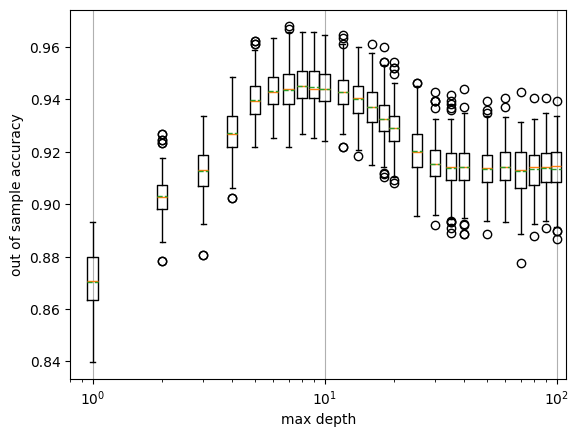

In [110]:
plt.figure()

df_select = df #df[df['min_samples_split'] == 2]

positions = []
x = []

for max_depth_ in sorted(df_select['max_depth'].unique()):

    # if max_depth_ not in [1, 2, 3, 4, 5, 6, 7, 8, 9,
    #                      10, 20, 30, 40, 50, 60, 70, 80, 90,
    #                     100, 200]:
    #     pass #continue
    
    x.append(
        df[df['max_depth'] == max_depth_]['accuracy_out_of_sample']
    )
    positions.append(
        max_depth_
    )

plt.boxplot(
    x,
    positions=positions,
    orientation='vertical',
    meanline=True,
    showmeans=True,
    widths=[0.1 * position for position in positions],
)
plt.xscale('log')
plt.xlim(xmin=0.8, xmax=110)
plt.xlabel('max depth')
plt.ylabel('out of sample accuracy')

plt.grid(axis='x')

plt.savefig('decision_tree_model_by_max_depth-accuracy_out_of_sample_AUC.png')
plt.savefig('decision_tree_model_by_max_depth-accuracy_out_of_sample_AUC.pdf')

None

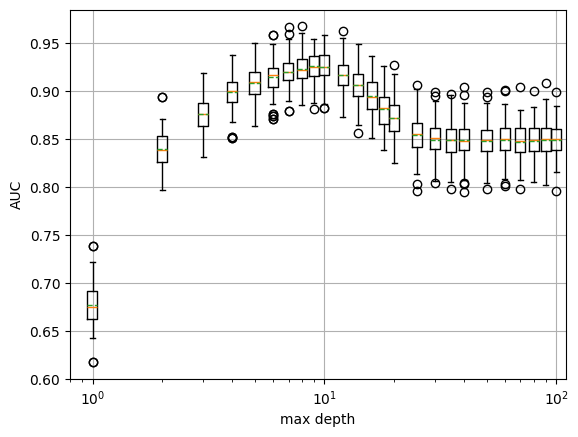

In [113]:
plt.figure()

df_select = df #df[df['min_samples_split'] == 2]

positions = []
x = []

for max_depth_ in sorted(df_select['max_depth'].unique()):

    # if max_depth_ not in [1, 2, 3, 4, 5, 6, 7, 8, 9,
    #                      10, 20, 30, 40, 50, 60, 70, 80, 90,
    #                     100, 200]:
    #     pass #continue
    
    x.append(
        df[df['max_depth'] == max_depth_]['auc']
    )
    positions.append(
        max_depth_
    )

plt.boxplot(
    x,
    positions=positions,
    orientation='vertical',
    meanline=True,
    showmeans=True,
    widths=[0.1 * position for position in positions],
)
plt.xscale('log')
plt.xlim(xmin=0.8, xmax=110)
plt.xlabel('max depth')
plt.ylabel('AUC')

plt.grid()

plt.savefig('decision_tree_model_by_max_depth-AUC.png')
plt.savefig('decision_tree_model_by_max_depth-AUC.pdf')

None

In [119]:
# make prediction

max_depth = 10
min_samples_split = 2
max_leaf_nodes = None
min_samples_leaf = 1
min_impurity_decrease = 0.0

auc_list = []
    
for i in range(k):
    test_index = folds[i]
    train_index = numpy.concatenate([folds[j] for j in range(k) if j != i])

    training_data = all_training_data.loc[train_index]
    test_data = all_training_data.loc[test_index]
    #training_data = all_training_data
    #test_data = all_training_data
    
    (
        clf,
        feature_importances,
        accuracy_in_sample,
    ) = decision_tree_model_train(
        training_data,
        decision_tree_columns,
        max_depth,
        min_samples_split,
        max_leaf_nodes,
        min_samples_leaf,
        min_impurity_decrease,
    )
    
    accuracy_out_of_sample = decision_tree_model_test(
        clf,
        test_data,
        decision_tree_columns,
    )
    
    auc_ = decision_tree_model_test_AUC(
        clf,
        test_data,
        decision_tree_columns,
    )
    auc_list.append(auc_)
    
    #data_predict = decision_tree_model_predict(
    #    clf,
    #    data_test_copy,
    #    decision_tree_columns,
    #    decision_tree_columns_with_id,
    #)
    
    #decision_tree_model_predict_write_to_csv(
    #    data_predict,
    #    f'decision_tree_model_one_hot_encoder_2_clean_code-2-AUC-2-max_depth_10.csv'
    #)
    #
    #auc_

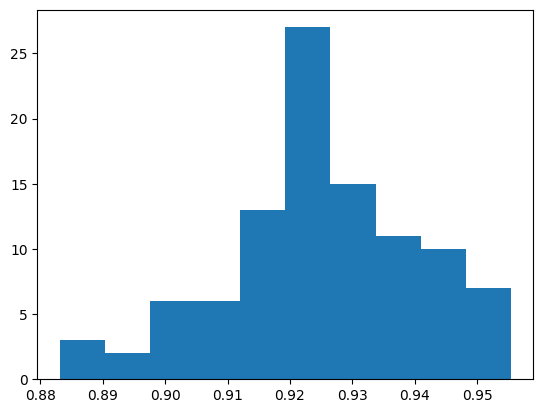

In [120]:
plt.figure()

plt.hist(auc_list)

None

In [117]:
# make prediction - no max depth, min samples split 30, min samples leaf 4
    
max_depth = None
min_samples_split = 30
max_leaf_nodes = None
min_samples_leaf = 4
min_impurity_decrease = 0.0

auc_list = []
    
for i in range(k):
    test_index = folds[i]
    train_index = numpy.concatenate([folds[j] for j in range(k) if j != i])
        
    training_data = all_training_data.loc[train_index]
    test_data = all_training_data.loc[test_index]
    #training_data = all_training_data
    #test_data = all_training_data
    
    (
        clf,
        feature_importances,
        accuracy_in_sample,
    ) = decision_tree_model_train(
        training_data,
        decision_tree_columns,
        max_depth,
        min_samples_split,
        max_leaf_nodes,
        min_samples_leaf,
        min_impurity_decrease,
    )
    
    accuracy_out_of_sample = decision_tree_model_test(
        clf,
        test_data,
        decision_tree_columns,
    )
    
    auc_ = decision_tree_model_test_AUC(
        clf,
        test_data,
        decision_tree_columns,
    )
    auc_list.append(auc_)
    
    #data_predict = decision_tree_model_predict(
    #    clf,
    #    data_test_copy,
    #    decision_tree_columns,
    #    decision_tree_columns_with_id,
    #)
    
    #decision_tree_model_predict_write_to_csv(
    #    data_predict,
    #    f'decision_tree_model_one_hot_encoder_2_clean_code-2-AUC-2-min_samples_split_30-min_samples_leaf_4.csv'
    #)
    
    #auc_

(array([ 2.,  3.,  3., 11., 25., 21., 14., 13.,  6.,  2.]),
 array([0.85773975, 0.86722621, 0.87671267, 0.88619913, 0.89568558,
        0.90517204, 0.9146585 , 0.92414496, 0.93363142, 0.94311787,
        0.95260433]),
 <BarContainer object of 10 artists>)

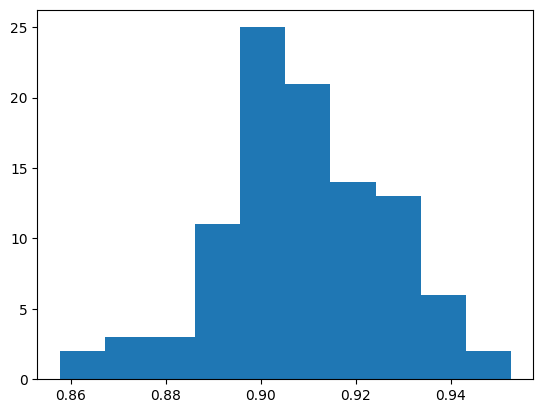

In [118]:
plt.figure()

plt.hist(auc_list)

None

# Decision Tree Model - Max Depth set to None, constrain Min Samples Split

In [ ]:
max_depth = None
min_samples_split = 2
max_leaf_nodes = None
min_samples_leaf = 1
min_impurity_decrease = 0.0

accuracy_in_sample_list = []
accuracy_out_of_sample_list = []
auc_list = []
max_depth_list = []
min_samples_split_list = []
max_leaf_nodes_list = []
min_samples_leaf_list = []
min_impurity_decrease_list = []

max_depth_list_input = [None]
min_samples_split_list_input = [2, 3, 4, 5, 7, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200, 300, 400, 500, 600, 700, 800, 900]
min_samples_split_list_input = [1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000]
max_leaf_nodes_list_input = [2, 4, 8, 16, 32]
min_samples_leaf_list_input = [1, 2, 4, 8, 16, 32]
min_impurity_decrease_list_input = [0.0, 0.001, 0.01, 0.1]

filename = f'decision_tree_model_by_min_samples_split_AUC.csv'

df = None

for min_samples_split in min_samples_split_list_input:
    print(f'processing min_samples_split={min_samples_split}')

    # read data from file
    if df is None:
        try:
            df = pandas.read_csv(filename, index_col=0)
        except:
            pass

        if df is not None:
            accuracy_in_sample_list = df['accuracy_in_sample'].to_numpy().tolist()
            accuracy_out_of_sample_list = df['accuracy_out_of_sample'].to_numpy().tolist()
            auc_list = df['auc'].to_numpy().tolist()
            max_depth_list = df['max_depth'].to_numpy().tolist()
            min_samples_split_list = df['min_samples_split'].to_numpy().tolist()
            max_leaf_nodes_list = df['max_leaf_nodes'].to_numpy().tolist()
            min_samples_leaf_list = df['min_samples_leaf'].to_numpy().tolist()
            min_impurity_decrease_list = df['min_impurity_decrease'].to_numpy().tolist()
    
    for i in range(k):
        test_index = folds[i]
        train_index = numpy.concatenate([folds[j] for j in range(k) if j != i])
            
        training_data = all_training_data.loc[train_index]
        test_data = all_training_data.loc[test_index]
        
        (
            clf,
            feature_importances,
            accuracy_in_sample,
        ) = decision_tree_model_train(
            training_data,
            decision_tree_columns,
            max_depth,
            min_samples_split,
            max_leaf_nodes,
            min_samples_leaf,
            min_impurity_decrease,
        )
        
        accuracy_out_of_sample = decision_tree_model_test(
            clf,
            test_data,
            decision_tree_columns,
        )

        auc_ = decision_tree_model_test_AUC(
            clf,
            test_data,
            decision_tree_columns,
        )
    
        accuracy_in_sample_list.append(accuracy_in_sample)
        accuracy_out_of_sample_list.append(accuracy_out_of_sample)
        auc_list.append(auc_)
        max_depth_list.append(max_depth)
        min_samples_split_list.append(min_samples_split)
        max_leaf_nodes_list.append(max_leaf_nodes)
        min_samples_leaf_list.append(min_samples_leaf)
        min_impurity_decrease_list.append(min_impurity_decrease)

    # write data to file
    df = pandas.DataFrame(
        {
            'max_depth': max_depth_list,
            'min_samples_split': min_samples_split_list,
            'max_leaf_nodes': max_leaf_nodes_list,
            'min_samples_leaf': min_samples_leaf_list,
            'min_impurity_decrease': min_impurity_decrease_list,
            'accuracy_in_sample': accuracy_in_sample_list,
            'accuracy_out_of_sample': accuracy_out_of_sample_list,
            'auc': auc_list,
            #'public_score': public_score_list,
            #'private_score': private_score_list,
        }
    )
    df['max_depth'] = df['max_depth'].astype(object)
    df['max_leaf_nodes'] = df['max_leaf_nodes'].astype(object)
    df.loc[df['max_depth'].isna(), 'max_depth'] = 'none'
    df.loc[df['max_leaf_nodes'].isna(), 'max_leaf_nodes'] = 'none'
    df.to_csv(filename, index=True)

print(f'done')

In [130]:
filename = f'decision_tree_model_by_min_samples_split_AUC.csv'
df = pandas.read_csv(filename, index_col=0)

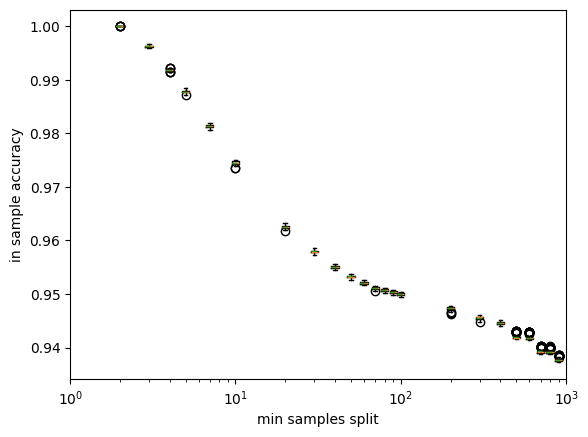

In [131]:
plt.figure()

df_select = df #df[df['min_samples_split'] == 2]

positions = []
x = []

for min_samples_split_ in sorted(df_select['min_samples_split'].unique()):
    x.append(
        df[df['min_samples_split'] == min_samples_split_]['accuracy_in_sample']
    )
    positions.append(
        min_samples_split_
    )

plt.boxplot(
    x,
    positions=positions,
    orientation='vertical',
    meanline=True,
    showmeans=True,
    widths=[0.1 * position for position in positions],
)
plt.xscale('log')
plt.xlim(xmin=1, xmax=1000)
plt.xlabel('min samples split')
plt.ylabel('in sample accuracy')

None

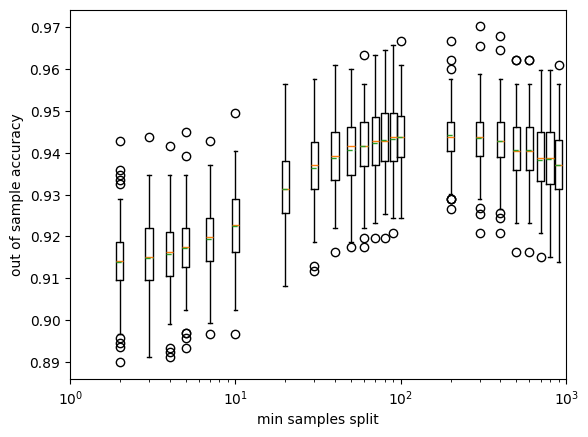

In [132]:
plt.figure()

df_select = df #df[df['min_samples_split'] == 2]

positions = []
x = []

for min_samples_split_ in sorted(df_select['min_samples_split'].unique()):

    # if not min_samples_split_ in [1, 2, 3, 4, 5, 6, 7, 8, 9,
    #                               10, 20, 30, 40, 50, 60, 70, 80, 90,
    #                               100, 200, 300, 400, 500, 600, 700, 800, 900,
    #                               1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000,
    #                               10000]:
    #     continue
    
    x.append(
        df[df['min_samples_split'] == min_samples_split_]['accuracy_out_of_sample']
    )
    positions.append(
        min_samples_split_
    )

plt.boxplot(
    x,
    positions=positions,
    orientation='vertical',
    meanline=True,
    showmeans=True,
    widths=[0.1 * position for position in positions],
)
plt.xscale('log')
plt.xlim(xmin=1, xmax=1000)
plt.xlabel('min samples split')
plt.ylabel('out of sample accuracy')

None

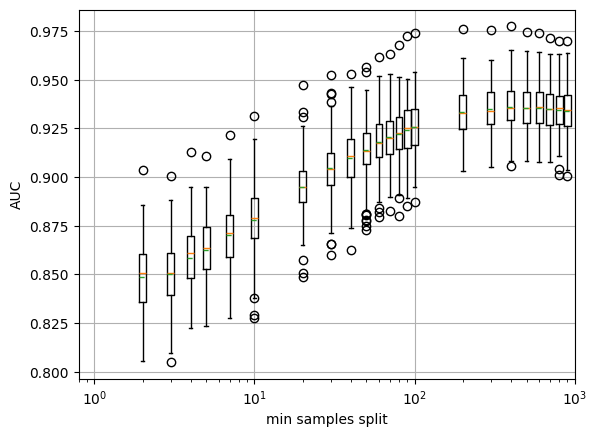

In [129]:
plt.figure()

df_select = df #df[df['min_samples_split'] == 2]

positions = []
x = []

for min_samples_split_ in sorted(df_select['min_samples_split'].unique()):
    
    x.append(
        df[df['min_samples_split'] == min_samples_split_]['auc']
    )
    positions.append(
        min_samples_split_
    )

plt.boxplot(
    x,
    positions=positions,
    orientation='vertical',
    meanline=True,
    showmeans=True,
    widths=[0.1 * position for position in positions],
)
plt.xscale('log')
plt.xlim(xmin=0.8, xmax=1000)
plt.xlabel('min samples split')
plt.ylabel('AUC')

plt.grid()

plt.savefig('decision_tree_model_by_min_samples_split-AUC.png')
plt.savefig('decision_tree_model_by_min_samples_split-AUC.pdf')

None

In [133]:
# make prediction

max_depth = None
min_samples_split = 400
max_leaf_nodes = None
min_samples_leaf = 1
min_impurity_decrease = 0.0

auc_list = []
    
for i in range(k):
    test_index = folds[i]
    train_index = numpy.concatenate([folds[j] for j in range(k) if j != i])

    training_data = all_training_data.loc[train_index]
    test_data = all_training_data.loc[test_index]
    #training_data = all_training_data
    #test_data = all_training_data
    
    (
        clf,
        feature_importances,
        accuracy_in_sample,
    ) = decision_tree_model_train(
        training_data,
        decision_tree_columns,
        max_depth,
        min_samples_split,
        max_leaf_nodes,
        min_samples_leaf,
        min_impurity_decrease,
    )
    
    accuracy_out_of_sample = decision_tree_model_test(
        clf,
        test_data,
        decision_tree_columns,
    )
    
    auc_ = decision_tree_model_test_AUC(
        clf,
        test_data,
        decision_tree_columns,
    )
    auc_list.append(auc_)
    
    #data_predict = decision_tree_model_predict(
    #    clf,
    #    data_test_copy,
    #    decision_tree_columns,
    #    decision_tree_columns_with_id,
    #)
    
    #decision_tree_model_predict_write_to_csv(
    #    data_predict,
    #    f'decision_tree_model_one_hot_encoder_2_clean_code-2-AUC-2-max_depth_10.csv'
    #)
    #
    #auc_

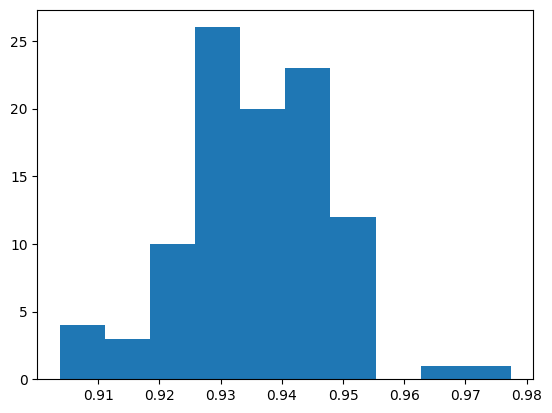

In [134]:
plt.figure()

plt.hist(auc_list)

None

# Decision Tree Model - Max Depth set to None, constrain Max Leaf Nodes

In [136]:
max_depth = None
min_samples_split = 2
max_leaf_nodes = None
min_samples_leaf = 1
min_impurity_decrease = 0.0

accuracy_in_sample_list = []
accuracy_out_of_sample_list = []
auc_list = []
max_depth_list = []
min_samples_split_list = []
max_leaf_nodes_list = []
min_samples_leaf_list = []
min_impurity_decrease_list = []

max_depth_list_input = [None]
min_samples_split_list_input = [2]
max_leaf_nodes_list_input = [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 1024 * 2, 1024 * 4, 1024 * 8]
min_samples_leaf_list_input = [1, 2, 4, 8, 16, 32]
min_impurity_decrease_list_input = [0.0, 0.001, 0.01, 0.1]

filename = f'decision_tree_model_by_max_leaf_nodes_AUC.csv'

df = None

for max_leaf_nodes in max_leaf_nodes_list_input:
    print(f'processing max_leaf_nodes={max_leaf_nodes}')

    # read data from file
    if df is None:
        try:
            df = pandas.read_csv(filename, index_col=0)
        except:
            pass

        if df is not None:
            accuracy_in_sample_list = df['accuracy_in_sample'].to_numpy().tolist()
            accuracy_out_of_sample_list = df['accuracy_out_of_sample'].to_numpy().tolist()
            auc_list = df['auc'].to_numpy().tolist()
            max_depth_list = df['max_depth'].to_numpy().tolist()
            min_samples_split_list = df['min_samples_split'].to_numpy().tolist()
            max_leaf_nodes_list = df['max_leaf_nodes'].to_numpy().tolist()
            min_samples_leaf_list = df['min_samples_leaf'].to_numpy().tolist()
            min_impurity_decrease_list = df['min_impurity_decrease'].to_numpy().tolist()
    
    for i in range(k):
        test_index = folds[i]
        train_index = numpy.concatenate([folds[j] for j in range(k) if j != i])
            
        training_data = all_training_data.loc[train_index]
        test_data = all_training_data.loc[test_index]
        
        (
            clf,
            feature_importances,
            accuracy_in_sample,
        ) = decision_tree_model_train(
            training_data,
            decision_tree_columns,
            max_depth,
            min_samples_split,
            max_leaf_nodes,
            min_samples_leaf,
            min_impurity_decrease,
        )
        
        accuracy_out_of_sample = decision_tree_model_test(
            clf,
            test_data,
            decision_tree_columns,
        )

        auc_ = decision_tree_model_test_AUC(
            clf,
            test_data,
            decision_tree_columns,
        )
    
        accuracy_in_sample_list.append(accuracy_in_sample)
        accuracy_out_of_sample_list.append(accuracy_out_of_sample)
        auc_list.append(auc_)
        max_depth_list.append(max_depth)
        min_samples_split_list.append(min_samples_split)
        max_leaf_nodes_list.append(max_leaf_nodes)
        min_samples_leaf_list.append(min_samples_leaf)
        min_impurity_decrease_list.append(min_impurity_decrease)

    # write data to file
    df = pandas.DataFrame(
        {
            'max_depth': max_depth_list,
            'min_samples_split': min_samples_split_list,
            'max_leaf_nodes': max_leaf_nodes_list,
            'min_samples_leaf': min_samples_leaf_list,
            'min_impurity_decrease': min_impurity_decrease_list,
            'accuracy_in_sample': accuracy_in_sample_list,
            'accuracy_out_of_sample': accuracy_out_of_sample_list,
            'auc': auc_list,
            #'public_score': public_score_list,
            #'private_score': private_score_list,
        }
    )
    df['max_depth'] = df['max_depth'].astype(object)
    df['max_leaf_nodes'] = df['max_leaf_nodes'].astype(object)
    df.loc[df['max_depth'].isna(), 'max_depth'] = 'none'
    df.loc[df['max_leaf_nodes'].isna(), 'max_leaf_nodes'] = 'none'
    df.to_csv(filename, index=True)

print(f'done')

processing max_leaf_nodes=2
processing max_leaf_nodes=4
processing max_leaf_nodes=8
processing max_leaf_nodes=16
processing max_leaf_nodes=32
processing max_leaf_nodes=64
processing max_leaf_nodes=128
processing max_leaf_nodes=256
processing max_leaf_nodes=512
processing max_leaf_nodes=1024
processing max_leaf_nodes=2048
processing max_leaf_nodes=4096
processing max_leaf_nodes=8192
done


In [137]:
filename = f'decision_tree_model_by_max_leaf_nodes_AUC.csv'
df = pandas.read_csv(filename, index_col=0)

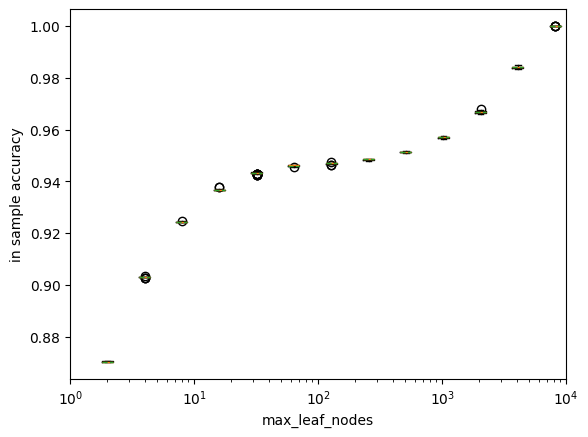

In [138]:
plt.figure()

df_select = df #df[df['min_samples_split'] == 2]

positions = []
x = []

for max_leaf_nodes_ in sorted(df_select['max_leaf_nodes'].unique()):
    x.append(
        df[df['max_leaf_nodes'] == max_leaf_nodes_]['accuracy_in_sample']
    )
    positions.append(
        max_leaf_nodes_
    )

plt.boxplot(
    x,
    positions=positions,
    orientation='vertical',
    meanline=True,
    showmeans=True,
    widths=[0.2 * position for position in positions],
)
plt.xscale('log')
plt.xlim(xmin=1, xmax=10000)
plt.xlabel('max_leaf_nodes')
plt.ylabel('in sample accuracy')

None

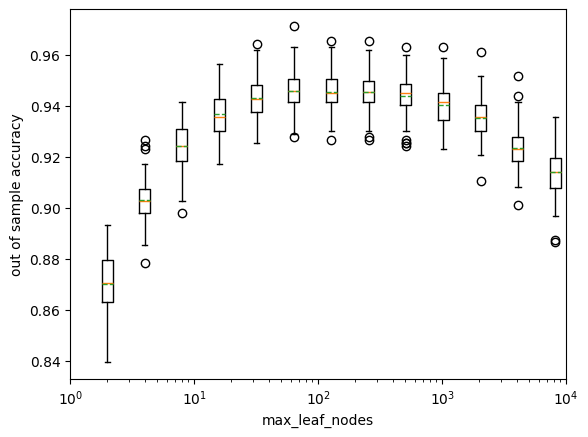

In [139]:
plt.figure()

df_select = df #df[df['min_samples_split'] == 2]

positions = []
x = []

for max_leaf_nodes_ in sorted(df_select['max_leaf_nodes'].unique()):
    x.append(
        df[df['max_leaf_nodes'] == max_leaf_nodes_]['accuracy_out_of_sample']
    )
    positions.append(
        max_leaf_nodes_
    )

plt.boxplot(
    x,
    positions=positions,
    orientation='vertical',
    meanline=True,
    showmeans=True,
    widths=[0.2 * position for position in positions],
)
plt.xscale('log')
plt.xlim(xmin=1, xmax=10000)
plt.xlabel('max_leaf_nodes')
plt.ylabel('out of sample accuracy')

None

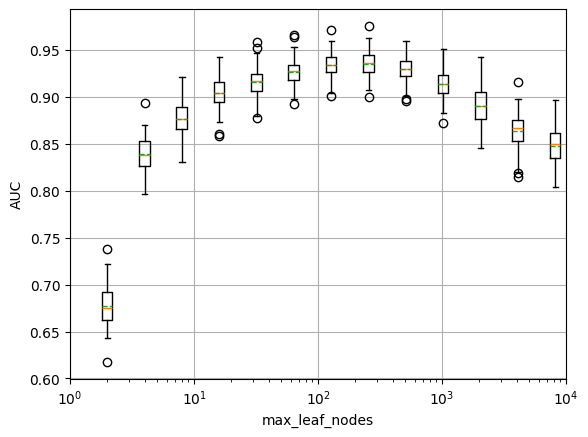

In [141]:
plt.figure()

df_select = df #df[df['min_samples_split'] == 2]

positions = []
x = []

for max_leaf_nodes_ in sorted(df_select['max_leaf_nodes'].unique()):
    x.append(
        df[df['max_leaf_nodes'] == max_leaf_nodes_]['auc']
    )
    positions.append(
        max_leaf_nodes_
    )

plt.boxplot(
    x,
    positions=positions,
    orientation='vertical',
    meanline=True,
    showmeans=True,
    widths=[0.2 * position for position in positions],
)
plt.xscale('log')
plt.xlim(xmin=1, xmax=10000)
plt.xlabel('max_leaf_nodes')
plt.ylabel('AUC')

plt.grid()

None

In [142]:
# make prediction

max_depth = None
min_samples_split = 2
max_leaf_nodes = 250
min_samples_leaf = 1
min_impurity_decrease = 0.0

auc_list = []
    
for i in range(k):
    test_index = folds[i]
    train_index = numpy.concatenate([folds[j] for j in range(k) if j != i])

    training_data = all_training_data.loc[train_index]
    test_data = all_training_data.loc[test_index]
    #training_data = all_training_data
    #test_data = all_training_data
    
    (
        clf,
        feature_importances,
        accuracy_in_sample,
    ) = decision_tree_model_train(
        training_data,
        decision_tree_columns,
        max_depth,
        min_samples_split,
        max_leaf_nodes,
        min_samples_leaf,
        min_impurity_decrease,
    )
    
    accuracy_out_of_sample = decision_tree_model_test(
        clf,
        test_data,
        decision_tree_columns,
    )
    
    auc_ = decision_tree_model_test_AUC(
        clf,
        test_data,
        decision_tree_columns,
    )
    auc_list.append(auc_)
    
    #data_predict = decision_tree_model_predict(
    #    clf,
    #    data_test_copy,
    #    decision_tree_columns,
    #    decision_tree_columns_with_id,
    #)
    
    #decision_tree_model_predict_write_to_csv(
    #    data_predict,
    #    f'decision_tree_model_one_hot_encoder_2_clean_code-2-AUC-2-max_depth_10.csv'
    #)
    #
    #auc_

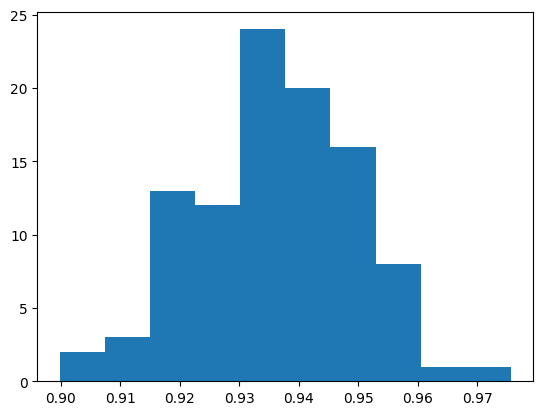

In [143]:
plt.figure()

plt.hist(auc_list)

None

# Decision Tree Model - Max Depth set to None, constrain Min Samples Leaf

In [144]:
max_depth = None
min_samples_split = 2
max_leaf_nodes = None
min_samples_leaf = 1
min_impurity_decrease = 0.0

accuracy_in_sample_list = []
accuracy_out_of_sample_list = []
auc_list = []
max_depth_list = []
min_samples_split_list = []
max_leaf_nodes_list = []
min_samples_leaf_list = []
min_impurity_decrease_list = []

max_depth_list_input = [None]
min_samples_split_list_input = [2]
max_leaf_nodes_list_input = [None]
min_samples_leaf_list_input = [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096, 8192]
min_impurity_decrease_list_input = [0.0, 0.001, 0.01, 0.1]

filename = f'decision_tree_model_by_min_samples_leaf_AUC.csv'

df = None

for min_samples_leaf in min_samples_leaf_list_input:
    print(f'processing min_samples_leaf={min_samples_leaf}')

    # read data from file
    if df is None:
        try:
            df = pandas.read_csv(filename, index_col=0)
        except:
            pass

        if df is not None:
            accuracy_in_sample_list = df['accuracy_in_sample'].to_numpy().tolist()
            accuracy_out_of_sample_list = df['accuracy_out_of_sample'].to_numpy().tolist()
            auc_list = df['auc'].to_numpy().tolist()
            max_depth_list = df['max_depth'].to_numpy().tolist()
            min_samples_split_list = df['min_samples_split'].to_numpy().tolist()
            max_leaf_nodes_list = df['max_leaf_nodes'].to_numpy().tolist()
            min_samples_leaf_list = df['min_samples_leaf'].to_numpy().tolist()
            min_impurity_decrease_list = df['min_impurity_decrease'].to_numpy().tolist()
    
    for i in range(k):
        test_index = folds[i]
        train_index = numpy.concatenate([folds[j] for j in range(k) if j != i])
            
        training_data = all_training_data.loc[train_index]
        test_data = all_training_data.loc[test_index]
        
        (
            clf,
            feature_importances,
            accuracy_in_sample,
        ) = decision_tree_model_train(
            training_data,
            decision_tree_columns,
            max_depth,
            min_samples_split,
            max_leaf_nodes,
            min_samples_leaf,
            min_impurity_decrease,
        )
        
        accuracy_out_of_sample = decision_tree_model_test(
            clf,
            test_data,
            decision_tree_columns,
        )

        auc_ = decision_tree_model_test_AUC(
            clf,
            test_data,
            decision_tree_columns,
        )
    
        accuracy_in_sample_list.append(accuracy_in_sample)
        accuracy_out_of_sample_list.append(accuracy_out_of_sample)
        auc_list.append(auc_)
        max_depth_list.append(max_depth)
        min_samples_split_list.append(min_samples_split)
        max_leaf_nodes_list.append(max_leaf_nodes)
        min_samples_leaf_list.append(min_samples_leaf)
        min_impurity_decrease_list.append(min_impurity_decrease)

    # write data to file
    df = pandas.DataFrame(
        {
            'max_depth': max_depth_list,
            'min_samples_split': min_samples_split_list,
            'max_leaf_nodes': max_leaf_nodes_list,
            'min_samples_leaf': min_samples_leaf_list,
            'min_impurity_decrease': min_impurity_decrease_list,
            'accuracy_in_sample': accuracy_in_sample_list,
            'accuracy_out_of_sample': accuracy_out_of_sample_list,
            'auc': auc_list,
            #'public_score': public_score_list,
            #'private_score': private_score_list,
        }
    )
    df['max_depth'] = df['max_depth'].astype(object)
    df['max_leaf_nodes'] = df['max_leaf_nodes'].astype(object)
    df.loc[df['max_depth'].isna(), 'max_depth'] = 'none'
    df.loc[df['max_leaf_nodes'].isna(), 'max_leaf_nodes'] = 'none'
    df.to_csv(filename, index=True)

print(f'done')

processing min_samples_leaf=1
processing min_samples_leaf=2
processing min_samples_leaf=4
processing min_samples_leaf=8
processing min_samples_leaf=16
processing min_samples_leaf=32
processing min_samples_leaf=64
processing min_samples_leaf=128
processing min_samples_leaf=256
processing min_samples_leaf=512
processing min_samples_leaf=1024
processing min_samples_leaf=2048
processing min_samples_leaf=4096
processing min_samples_leaf=8192
done


In [145]:
filename = f'decision_tree_model_by_min_samples_leaf_AUC.csv'
df = pandas.read_csv(filename, index_col=0)

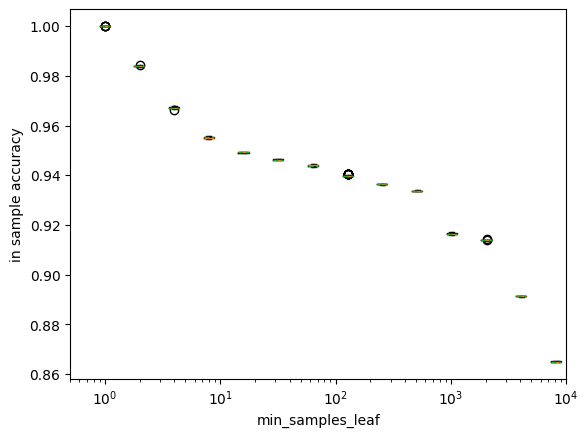

In [146]:
plt.figure()

df_select = df #df[df['min_samples_split'] == 2]

positions = []
x = []

for min_samples_leaf_ in sorted(df_select['min_samples_leaf'].unique()):
    x.append(
        df[df['min_samples_leaf'] == min_samples_leaf_]['accuracy_in_sample']
    )
    positions.append(
        min_samples_leaf_
    )

plt.boxplot(
    x,
    positions=positions,
    orientation='vertical',
    meanline=True,
    showmeans=True,
    widths=[0.2 * position for position in positions],
)
plt.xscale('log')
plt.xlim(xmin=0.5, xmax=10000)
plt.xlabel('min_samples_leaf')
plt.ylabel('in sample accuracy')

None

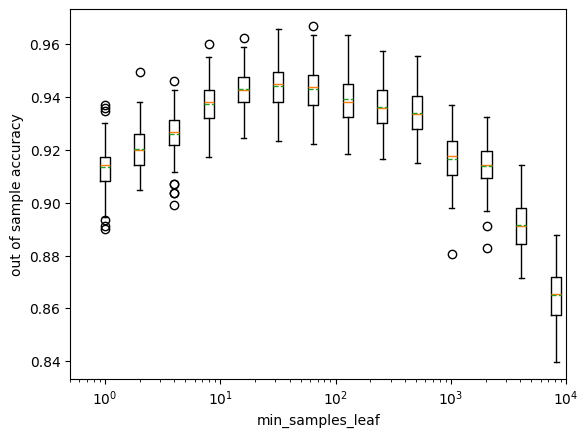

In [147]:
plt.figure()

df_select = df #df[df['min_samples_split'] == 2]

positions = []
x = []

for min_samples_leaf_ in sorted(df_select['min_samples_leaf'].unique()):
    x.append(
        df[df['min_samples_leaf'] == min_samples_leaf_]['accuracy_out_of_sample']
    )
    positions.append(
        min_samples_leaf_
    )

plt.boxplot(
    x,
    positions=positions,
    orientation='vertical',
    meanline=True,
    showmeans=True,
    widths=[0.2 * position for position in positions],
)
plt.xscale('log')
plt.xlim(xmin=0.5, xmax=10000)
plt.xlabel('min_samples_leaf')
plt.ylabel('out of sample accuracy')

None

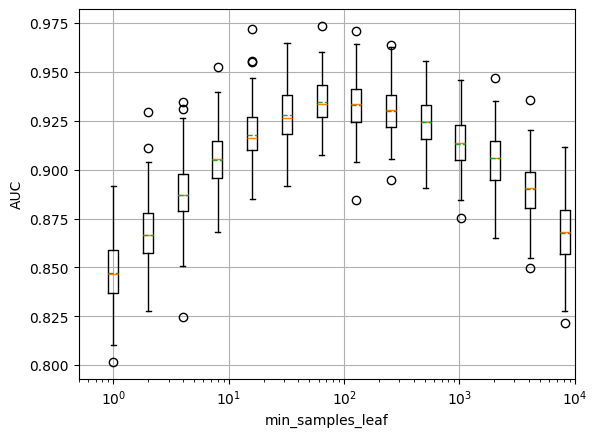

In [149]:
plt.figure()

df_select = df #df[df['min_samples_split'] == 2]

positions = []
x = []

for min_samples_leaf_ in sorted(df_select['min_samples_leaf'].unique()):
    x.append(
        df[df['min_samples_leaf'] == min_samples_leaf_]['auc']
    )
    positions.append(
        min_samples_leaf_
    )

plt.boxplot(
    x,
    positions=positions,
    orientation='vertical',
    meanline=True,
    showmeans=True,
    widths=[0.2 * position for position in positions],
)
plt.xscale('log')
plt.xlim(xmin=0.5, xmax=10000)
plt.xlabel('min_samples_leaf')
plt.ylabel('AUC')

plt.grid()

None

In [150]:
# make prediction

max_depth = None
min_samples_split = 2
max_leaf_nodes = None
min_samples_leaf = 64
min_impurity_decrease = 0.0

auc_list = []
    
for i in range(k):
    test_index = folds[i]
    train_index = numpy.concatenate([folds[j] for j in range(k) if j != i])

    training_data = all_training_data.loc[train_index]
    test_data = all_training_data.loc[test_index]
    #training_data = all_training_data
    #test_data = all_training_data
    
    (
        clf,
        feature_importances,
        accuracy_in_sample,
    ) = decision_tree_model_train(
        training_data,
        decision_tree_columns,
        max_depth,
        min_samples_split,
        max_leaf_nodes,
        min_samples_leaf,
        min_impurity_decrease,
    )
    
    accuracy_out_of_sample = decision_tree_model_test(
        clf,
        test_data,
        decision_tree_columns,
    )
    
    auc_ = decision_tree_model_test_AUC(
        clf,
        test_data,
        decision_tree_columns,
    )
    auc_list.append(auc_)
    
    #data_predict = decision_tree_model_predict(
    #    clf,
    #    data_test_copy,
    #    decision_tree_columns,
    #    decision_tree_columns_with_id,
    #)
    
    #decision_tree_model_predict_write_to_csv(
    #    data_predict,
    #    f'decision_tree_model_one_hot_encoder_2_clean_code-2-AUC-2-max_depth_10.csv'
    #)
    #
    #auc_

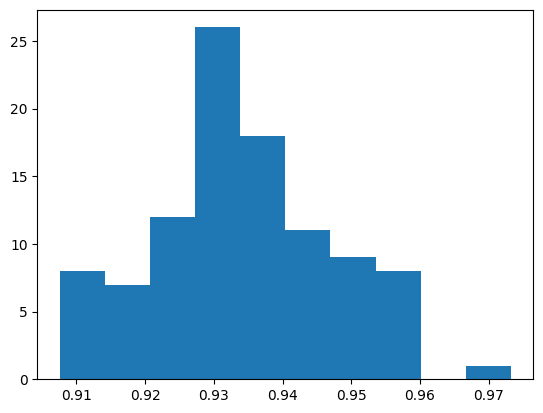

In [151]:
plt.figure()

plt.hist(auc_list)

None

# Decision Tree Model - Max Depth set to None, constrain Min Impurity Decrease

In [152]:
max_depth = None
min_samples_split = 2
max_leaf_nodes = None
min_samples_leaf = 1
min_impurity_decrease = 0.0

accuracy_in_sample_list = []
accuracy_out_of_sample_list = []
auc_list = []
max_depth_list = []
min_samples_split_list = []
max_leaf_nodes_list = []
min_samples_leaf_list = []
min_impurity_decrease_list = []

max_depth_list_input = [None]
min_samples_split_list_input = [2]
max_leaf_nodes_list_input = [None]
min_samples_leaf_list_input = [1]
min_impurity_decrease_list_input = [
    1.0e-5, 2.0e-5, 3.0e-5, 4.0e-5, 5.0e-5, 6.0e-5, 7.0e-5, 8.0e-5, 9.0e-5,
    1.0e-4, 2.0e-4, 3.0e-4, 4.0e-4, 5.0e-4, 6.0e-4, 7.0e-4, 8.0e-4, 9.0e-4,
    1.0e-3, 2.0e-3, 3.0e-3, 4.0e-3, 5.0e-3, 6.0e-3, 7.0e-3, 8.0e-3, 9.0e-3,
    1.0e-2,
]

filename = f'decision_tree_model_by_min_impurity_decrease_AUC.csv'

df = None

for min_impurity_decrease in min_impurity_decrease_list_input:
    print(f'processing min_impurity_decrease={min_impurity_decrease}')

    # read data from file
    if df is None:
        try:
            df = pandas.read_csv(filename, index_col=0)
        except:
            pass

        if df is not None:
            accuracy_in_sample_list = df['accuracy_in_sample'].to_numpy().tolist()
            accuracy_out_of_sample_list = df['accuracy_out_of_sample'].to_numpy().tolist()
            auc_list = df['auc'].to_numpy().tolist()
            max_depth_list = df['max_depth'].to_numpy().tolist()
            min_samples_split_list = df['min_samples_split'].to_numpy().tolist()
            max_leaf_nodes_list = df['max_leaf_nodes'].to_numpy().tolist()
            min_samples_leaf_list = df['min_samples_leaf'].to_numpy().tolist()
            min_impurity_decrease_list = df['min_impurity_decrease'].to_numpy().tolist()
    
    for i in range(k):
        test_index = folds[i]
        train_index = numpy.concatenate([folds[j] for j in range(k) if j != i])
            
        training_data = all_training_data.loc[train_index]
        test_data = all_training_data.loc[test_index]
        
        (
            clf,
            feature_importances,
            accuracy_in_sample,
        ) = decision_tree_model_train(
            training_data,
            decision_tree_columns,
            max_depth,
            min_samples_split,
            max_leaf_nodes,
            min_samples_leaf,
            min_impurity_decrease,
        )
        
        accuracy_out_of_sample = decision_tree_model_test(
            clf,
            test_data,
            decision_tree_columns,
        )

        auc_ = decision_tree_model_test_AUC(
            clf,
            test_data,
            decision_tree_columns,
        )
    
        accuracy_in_sample_list.append(accuracy_in_sample)
        accuracy_out_of_sample_list.append(accuracy_out_of_sample)
        auc_list.append(auc_)
        max_depth_list.append(max_depth)
        min_samples_split_list.append(min_samples_split)
        max_leaf_nodes_list.append(max_leaf_nodes)
        min_samples_leaf_list.append(min_samples_leaf)
        min_impurity_decrease_list.append(min_impurity_decrease)

    # write data to file
    df = pandas.DataFrame(
        {
            'max_depth': max_depth_list,
            'min_samples_split': min_samples_split_list,
            'max_leaf_nodes': max_leaf_nodes_list,
            'min_samples_leaf': min_samples_leaf_list,
            'min_impurity_decrease': min_impurity_decrease_list,
            'accuracy_in_sample': accuracy_in_sample_list,
            'accuracy_out_of_sample': accuracy_out_of_sample_list,
            'auc': auc_list,
            #'public_score': public_score_list,
            #'private_score': private_score_list,
        }
    )
    df['max_depth'] = df['max_depth'].astype(object)
    df['max_leaf_nodes'] = df['max_leaf_nodes'].astype(object)
    df.loc[df['max_depth'].isna(), 'max_depth'] = 'none'
    df.loc[df['max_leaf_nodes'].isna(), 'max_leaf_nodes'] = 'none'
    df.to_csv(filename, index=True)

print(f'done')

processing min_impurity_decrease=1e-05
processing min_impurity_decrease=2e-05
processing min_impurity_decrease=3e-05
processing min_impurity_decrease=4e-05
processing min_impurity_decrease=5e-05
processing min_impurity_decrease=6e-05
processing min_impurity_decrease=7e-05
processing min_impurity_decrease=8e-05
processing min_impurity_decrease=9e-05
processing min_impurity_decrease=0.0001
processing min_impurity_decrease=0.0002
processing min_impurity_decrease=0.0003
processing min_impurity_decrease=0.0004
processing min_impurity_decrease=0.0005
processing min_impurity_decrease=0.0006
processing min_impurity_decrease=0.0007
processing min_impurity_decrease=0.0008
processing min_impurity_decrease=0.0009
processing min_impurity_decrease=0.001
processing min_impurity_decrease=0.002
processing min_impurity_decrease=0.003
processing min_impurity_decrease=0.004
processing min_impurity_decrease=0.005
processing min_impurity_decrease=0.006
processing min_impurity_decrease=0.007
processing min_i

In [153]:
filename = f'decision_tree_model_by_min_impurity_decrease_AUC.csv'
df = pandas.read_csv(filename, index_col=0)

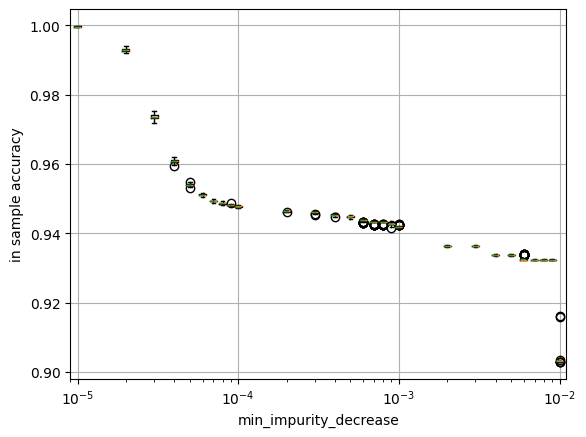

In [160]:
plt.figure()

df_select = df #df[df['min_samples_split'] == 2]

positions = []
x = []

for min_impurity_decrease_ in sorted(df_select['min_impurity_decrease'].unique()):

    x.append(
        df[df['min_impurity_decrease'] == min_impurity_decrease_]['accuracy_in_sample']
    )
    positions.append(
        min_impurity_decrease_
    )

plt.boxplot(
    x,
    positions=positions,
    orientation='vertical',
    meanline=True,
    showmeans=True,
    widths=[0.1 * position for position in positions],
)
plt.xscale('log')
plt.xlim(xmin=0.9e-5, xmax=1.1e-2)
plt.xlabel('min_impurity_decrease')
plt.ylabel('in sample accuracy')
plt.grid()

None

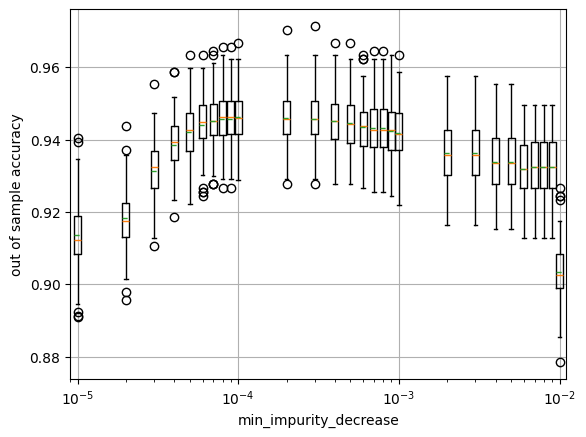

In [161]:
plt.figure()

df_select = df #df[df['min_samples_split'] == 2]

positions = []
x = []

for min_impurity_decrease_ in sorted(df_select['min_impurity_decrease'].unique()):

    x.append(
        df[df['min_impurity_decrease'] == min_impurity_decrease_]['accuracy_out_of_sample']
    )
    positions.append(
        min_impurity_decrease_
    )

plt.boxplot(
    x,
    positions=positions,
    orientation='vertical',
    meanline=True,
    showmeans=True,
    widths=[0.1 * position for position in positions],
)
plt.xscale('log')
plt.xlim(xmin=0.9e-5, xmax=1.1e-2)
plt.xlabel('min_impurity_decrease')
plt.ylabel('out of sample accuracy')
plt.grid()

None

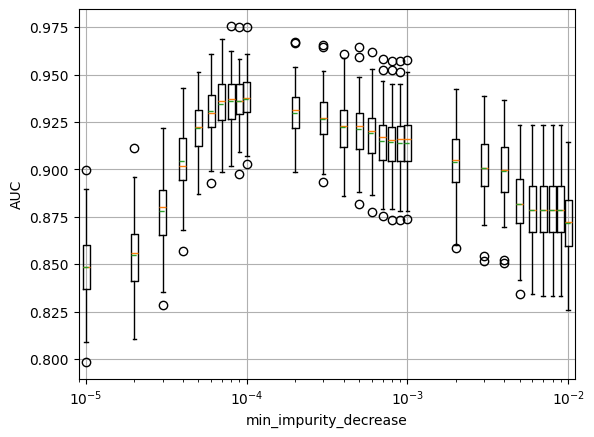

In [163]:
plt.figure()

df_select = df #df[df['min_samples_split'] == 2]

positions = []
x = []

for min_impurity_decrease_ in sorted(df_select['min_impurity_decrease'].unique()):

    x.append(
        df[df['min_impurity_decrease'] == min_impurity_decrease_]['auc']
    )
    positions.append(
        min_impurity_decrease_
    )

plt.boxplot(
    x,
    positions=positions,
    orientation='vertical',
    meanline=True,
    showmeans=True,
    widths=[0.1 * position for position in positions],
)
plt.xscale('log')
plt.xlim(xmin=0.9e-5, xmax=1.1e-2)
plt.xlabel('min_impurity_decrease')
plt.ylabel('AUC')
plt.grid()

None

In [165]:
# make prediction

max_depth = None
min_samples_split = 2
max_leaf_nodes = None
min_samples_leaf = 1
min_impurity_decrease = 1.0e-4

auc_list = []
    
for i in range(k):
    test_index = folds[i]
    train_index = numpy.concatenate([folds[j] for j in range(k) if j != i])

    training_data = all_training_data.loc[train_index]
    test_data = all_training_data.loc[test_index]
    #training_data = all_training_data
    #test_data = all_training_data
    
    (
        clf,
        feature_importances,
        accuracy_in_sample,
    ) = decision_tree_model_train(
        training_data,
        decision_tree_columns,
        max_depth,
        min_samples_split,
        max_leaf_nodes,
        min_samples_leaf,
        min_impurity_decrease,
    )
    
    accuracy_out_of_sample = decision_tree_model_test(
        clf,
        test_data,
        decision_tree_columns,
    )
    
    auc_ = decision_tree_model_test_AUC(
        clf,
        test_data,
        decision_tree_columns,
    )
    auc_list.append(auc_)
    
    #data_predict = decision_tree_model_predict(
    #    clf,
    #    data_test_copy,
    #    decision_tree_columns,
    #    decision_tree_columns_with_id,
    #)
    
    #decision_tree_model_predict_write_to_csv(
    #    data_predict,
    #    f'decision_tree_model_one_hot_encoder_2_clean_code-2-AUC-2-max_depth_10.csv'
    #)
    #
    #auc_

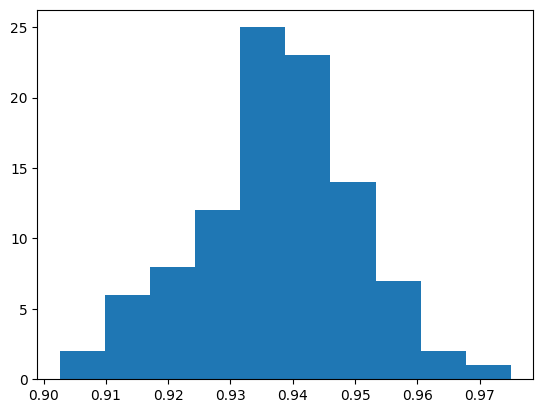

In [166]:
plt.figure()

plt.hist(auc_list)

None

In [167]:
# train with everything

max_depth = None
min_samples_split = 2
max_leaf_nodes = None
min_samples_leaf = 1
min_impurity_decrease = 1.0e-4

#i = 0

#test_index = folds[i]
#train_index = numpy.concatenate([folds[j] for j in range(k) if j != i])
            
#training_data = all_training_data.loc[train_index]
#test_data = all_training_data.loc[test_index]
training_data = all_training_data
test_data = all_training_data

(
    clf,
    feature_importances,
    accuracy_in_sample,
) = decision_tree_model_train(
    training_data,
    decision_tree_columns,
    max_depth,
    min_samples_split,
    max_leaf_nodes,
    min_samples_leaf,
    min_impurity_decrease,
)

# accuracy_out_of_sample = decision_tree_model_test(
#     clf,
#     test_data,
#     decision_tree_columns,
# )

# (tpr, fpr) = decision_tree_model_test_TPR_FPR(
#     clf,
#     test_data,
#     decision_tree_columns,
#     0.5,
# )

data_predict = decision_tree_model_predict(
    clf,
    data_test_copy,
    decision_tree_columns,
    decision_tree_columns_with_id,
)

decision_tree_model_predict_write_to_csv(
    data_predict,
    f'decision_tree_model_one_hot_encoder_2_clean_code-2-AUC_min_impurity_decrease_1.0e-4_all_training_data.csv'
)

In [ ]:
# private: 0.93837
# public: 0.93695